In [1]:
import gym
import gym_Snake
import time
import sys
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#### QLearning algorithm

In [2]:
class QLearning:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = decay
        
    def act(self):
        ## by default, act greedily
        if (np.random.uniform() < self.epsilon):
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[self.state, :])
    
    def update(self, action, reward, state):
        ## fill in
        Q_max = max(self.Q[state, :])
        self.Q[self.state, action] = self.alpha * (reward + self.discount * Q_max) + (1.0 - self.alpha) * self.Q[self.state, action]
        self.state = state

    def reset(self, state):
        self.state = state


In [12]:
class QLearning2:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = decay
        
    def act(self):
        self.epsilon = 1 / (1 / self.epsilon + self.decay)
        if (np.random.uniform() < self.epsilon):
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[self.state, :])
    
    def update(self, action, reward, state):
        self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])
        self.alpha += 1 / ( self.alpha + self.decay)
        self.state = state

    def reset(self, state):
        self.state = state


In [19]:
class SARSA:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = decay
        self.state = 0  # Set initial state

    def act(self):
        ## by default, act greedily
        if (np.random.uniform() < self.epsilon):
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[self.state, :])

    def update(self, action, reward, state):
        ## fill in
        next_action = np.argmax(self.Q[state, :])
        self.Q[self.state, action] = self.alpha * (reward + self.discount * self.Q[state, next_action]) + (1 - self.alpha) * self.Q[self.state, action]
        self.state = state

    def reset(self, state):
        self.state = state

#### Create env

In [3]:
env = gym.make('Snake-v0', 
               player='computer', 
               shape='Normal', 
               state_mode='states', 
               reward_mode = 'extended', 
               width=9, 
               height=9, 
               solid_border=True)
print(env.observation_space)
print(env.action_space)

Discrete(1024)
Discrete(3)


#### Init QLearning algorithm

In [20]:
QL = QLearning(n_actions = env.action_space.n, n_states = env.observation_space.n)
QL2 = QLearning(n_actions = env.action_space.n, n_states = env.observation_space.n, discount=0.9, alpha = 0.01, epsilon=0.9, decay = 0.01)
SA = SARSA(n_actions = env.action_space.n, n_states = env.observation_space.n)

In [5]:
def play_epoch(algo, env, render = False):
    
    # Reset env
    obs = env.reset()
    algo.reset(obs)

    done = False
    
    # Sum the rewards
    total_rew = 0
    
    while not done:
        # Show
        if render: env.render()
        # Choose next action
        new_act = algo.act()
        # Act in the env
        obs, reward, done, info = env.step(np.random.randint(3))
        # Store reward
        total_rew += reward
        # Update algorithm
        algo.update(new_act, reward, obs)
        # Slow render
        if render: time.sleep(0.5)
            
    # Return total reward
    return total_rew

#### Train

In [21]:
render = True

nb_iterations = 50000

rewards = []

# Train
for i in tqdm(range(nb_iterations)):
    r = play_epoch(algo = SA, env = env, render = False)
    rewards.append(r)
    

# Visualize results
# play_epoch(algo = QL, env = env, render = True)

100%|████████████████████████████████████| 50000/50000 [00:55<00:00, 906.12it/s]


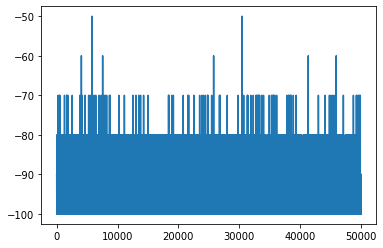

In [22]:
plt.plot(range(len(rewards)), rewards)

#### Visualize results

In [9]:
# Replay with last policy
play_epoch(algo = QL, env = env, render = True)

-100